# Train the DriveSafe model with RNN (LSTM)

Takes fixed-length video snippets as inputs and produces a label output

- Driving simulator [here](https://www.crazygames.com/game/city-car-driving-simulator)
- Built based on this [towardsdatascience article](https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470)
- [pyimagesearch](https://pyimagesearch.com/2019/07/15/video-classification-with-keras-and-deep-learning/) article

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
# from IPython.display import HTML

InteractiveShell.ast_node_interactivity = 'all'

In [3]:
# import the necessary packages
import numpy as np
import os
import argparse
import pickle
from utils.data import get_sequence_data
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Flatten, Input, AveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Configurations

In [4]:
# config vars

DATASET_PATH = "data"
OUTPUT_PATH = "model"
FRAMES_PER_SEQ = 30
LABELS = set(["collision", "safe", "tailgating", "weaving"])

NUM_EPOCHS = 25 #150
BATCH_SIZE = 32 #2048
PATIENCE = 50

# Load Input Data

In [5]:
# load sequence data
print("[INFO] loading sequence data...")
data, labels = get_sequence_data(DATASET_PATH, LABELS, FRAMES_PER_SEQ)

# convert the data and labels to numpy arrays
training_data = np.array(data["training"])
training_labels = np.array(labels["training"])
validation_data = np.array(data["validation"])
validation_labels = np.array(labels["validation"])

# count number of sequences
print(f"[INFO] number of sequences in training_data: {len(training_data)}")
print(f"[INFO] number of sequences in validation_data: {len(validation_data)}")

# perform one-hot encoding on the labels
lb = LabelBinarizer()
training_labels = lb.fit_transform(training_labels)
validation_labels = lb.transform(validation_labels) # use transform instead of fit_transform because we want to use the same encoder as the training data

[INFO] loading sequence data...
[INFO] number of sequences in training_data: 246
[INFO] number of sequences in validation_data: 24


# Pre-processing
We want to reshape trainX like this: (num_sequences, FRAMES_PER_SEQ, 224, 224, 3) --> (num_sequences, FRAMES_PER_SEQ, IMAGE_DATA)

In [6]:
# partition the data into training and testing splits
# (trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, stratify=labels, random_state=42)
trainX = training_data
testX = validation_data
trainY = training_labels
testY = validation_labels

# Load ResNet50 model without the top layer
# resnet50_model = ResNet50(weights="imagenet", include_top=False)
# def preprocess_sequence(sequence):
#     # Preprocess each image in the sequence and extract features using ResNet50
#     features_sequence = [resnet50_model.predict(np.expand_dims(img, axis=0)) for img in sequence]
#     return features_sequence


# trainX has the shape (num_sequences, FRAMES_PER_SEQ, 224, 224, 3)
# trainX = trainX.reshape(trainX.shape[0], FRAMES_PER_SEQ, -1)  # Reshaping each sequence of N frames into a single time step
# testX = testX.reshape(testX.shape[0], FRAMES_PER_SEQ, -1) # equiv to saying `testX.reshape(NUM_SEQUENCES_IN_TEST_X, FRAMES_PER_SEQ, -1)`
# trainX_resnet = [preprocess_sequence(sequence) for sequence in trainX]
# testX_resnet = [preprocess_sequence(sequence) for sequence in testX]


# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# initialize the validation/testing data augmentation object (which we'll be adding mean subtraction to)
valAug = ImageDataGenerator()

# define the ImageNet mean subtraction (in RGB order) and set the the mean subtraction value for each of the data augmentation objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

# Train the Model

In [7]:
from tensorflow.keras.layers import Input,AveragePooling2D
from tensorflow.keras.models import Model

# load the ResNet-50 network, ensuring the head FC layer sets are left off
baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# loop over all layers in the base model and freeze them so they will *not* be updated during the training process
for layer in baseModel.layers:
    layer.trainable = False

# construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
# headModel = Dense(len(lb.classes_), activation="softmax")(headModel) # output layer
# headModel = Flatten()(headModel) # flatten cnn output to fit LSTM input shape

# place the head FC model on top of the base model (this will become the actual model we will train)
cnn_model = Model(inputs=baseModel.input, outputs=headModel)

# Define LSTM model
lstm_model = Sequential()
lstm_model.add(Input(shape=(FRAMES_PER_SEQ, headModel.shape[1])))
lstm_model.add(LSTM(128, return_sequences=False))
lstm_model.add(Dropout(0.5))

# Combine the ResNet (cnn_model) and LSTM models
combined_model = Sequential()
combined_model.add(Input(shape=((None, FRAMES_PER_SEQ, 224, 224, 3))))
combined_model.add(TimeDistributed(cnn_model)) # https://keras.io/api/layers/recurrent_layers/time_distributed/
# combined_model.add(TimeDistributed(cnn_model, input_shape=baseModel.input_shape[1:]))
combined_model.add(lstm_model)
lstm_model.add(Dense(len(lb.classes_), activation="softmax")) # output layer

# initialize the model
# model = Sequential()
# model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(0.5))
# model.add(Dense(len(lb.classes_), activation="softmax"))

# callbacks
# patience sets how many epochs to run for before stopping (if no more improvements are made)
# callbacks = [EarlyStopping(monitor='val_loss', patience=PATIENCE),
#              ModelCheckpoint(os.path.join(OUTPUT_PATH, 'checkpoint.keras'), save_best_only=True, save_weights_only=False)]
callbacks = []

# compile the model
# combined_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
print("[INFO] compiling model...")
opt = SGD(learning_rate=1e-4, momentum=0.9, decay=1e-4 / NUM_EPOCHS)
combined_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])


# train the model
print("[INFO] training model...")
history = combined_model.fit(trainX, trainY, validation_data=(testX, testY), callbacks=callbacks, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)
# history =  combined_model.fit(
# 	x=trainAug.flow(trainX, trainY, batch_size=BATCH_SIZE),
# 	steps_per_epoch=len(trainX) // BATCH_SIZE,
# 	validation_data=valAug.flow(testX, testY),
# 	validation_steps=len(testX) // BATCH_SIZE,
# 	epochs=NUM_EPOCHS)
NUM_EPOCHS = len(history.history['loss'])

# print model summary
combined_model.summary()

[INFO] compiling model...
[INFO] training model...
Epoch 1/25


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 207s 20s/step - accuracy: 0.2277 - loss: 1.6526 - val_accuracy: 0.3750 - val_loss: 1.4435
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 140s 18s/step - accuracy: 0.2486 - loss: 1.5426 - val_accuracy: 0.4583 - val_loss: 1.3531
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 139s 18s/step - accuracy: 0.2419 - loss: 1.4980 - val_accuracy: 0.4167 - val_loss: 1.3082
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 138s 17s/step - accuracy: 0.2672 - loss: 1.4258 - val_accuracy: 0.3333 - val_loss: 1.2752
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 142s 18s/step - accuracy: 0.2643 - loss: 1.4365 - val_accuracy: 0.4167 - val_loss: 1.2346
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 138s 17s/step - accuracy: 0.2983 - loss: 1.3474 - val_accuracy: 0.5417 - val_loss: 1.1973
Epoch 7/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 209s 18s/step - accuracy: 0.3956 - loss: 1.2780 - val_accuracy: 0.7083 - val_loss: 1.1597
Epoch 8/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 137s 17s/step - accuracy: 0.3747 - loss: 1.3371 - val_accuracy: 0.7500 - val_loss: 1.1201
Epo

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ ?                      │    24,636,800 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ ?                      │       328,708 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,343,306 (100.49 MB)

 Trainable params: 1,377,796 (5.26 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 1,377,798 (5.26 MB)

# Evaluate the Model

[INFO] evaluating model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step
              precision    recall  f1-score   support

   collision       0.50      0.83      0.62         6
        safe       1.00      1.00      1.00         6
  tailgating       0.00      0.00      0.00         6
     weaving       0.75      1.00      0.86         6

    accuracy                           0.71        24
   macro avg       0.56      0.71      0.62        24
weighted avg       0.56      0.71      0.62        24



/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Training Loss and Accuracy')

Text(0.5, 0, 'Epoch #')

Text(0, 0.5, 'Loss/Accuracy')

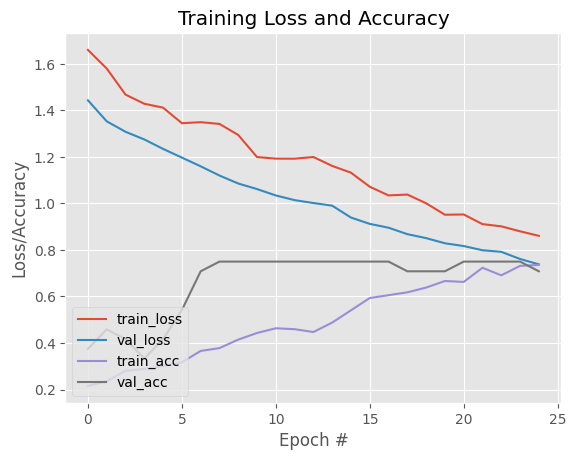

In [9]:
# evaluate the model
print("[INFO] evaluating model...")
predictions = combined_model.predict(testX, batch_size=BATCH_SIZE)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=lb.classes_))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, NUM_EPOCHS), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, NUM_EPOCHS), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, NUM_EPOCHS), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, NUM_EPOCHS), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(os.path.join(OUTPUT_PATH, "plot.png"))

# Save Output to Disk

In [11]:
# serialize the model to disk
print("[INFO] serializing model...")
combined_model.save(os.path.join(OUTPUT_PATH, "model.keras"))

# serialize the label binarizer to disk
with open(os.path.join(OUTPUT_PATH, "labels.pickle"), "wb") as f:
    f.write(pickle.dumps(lb))

[INFO] serializing model...


483